In [1]:
from pyADAPT.io import read_data_raw, read_mat


In [2]:
from pyADAPT.io import read_data_raw, read_mat
from mat4py import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pyADAPT.dataset import DataSet, plot_splines


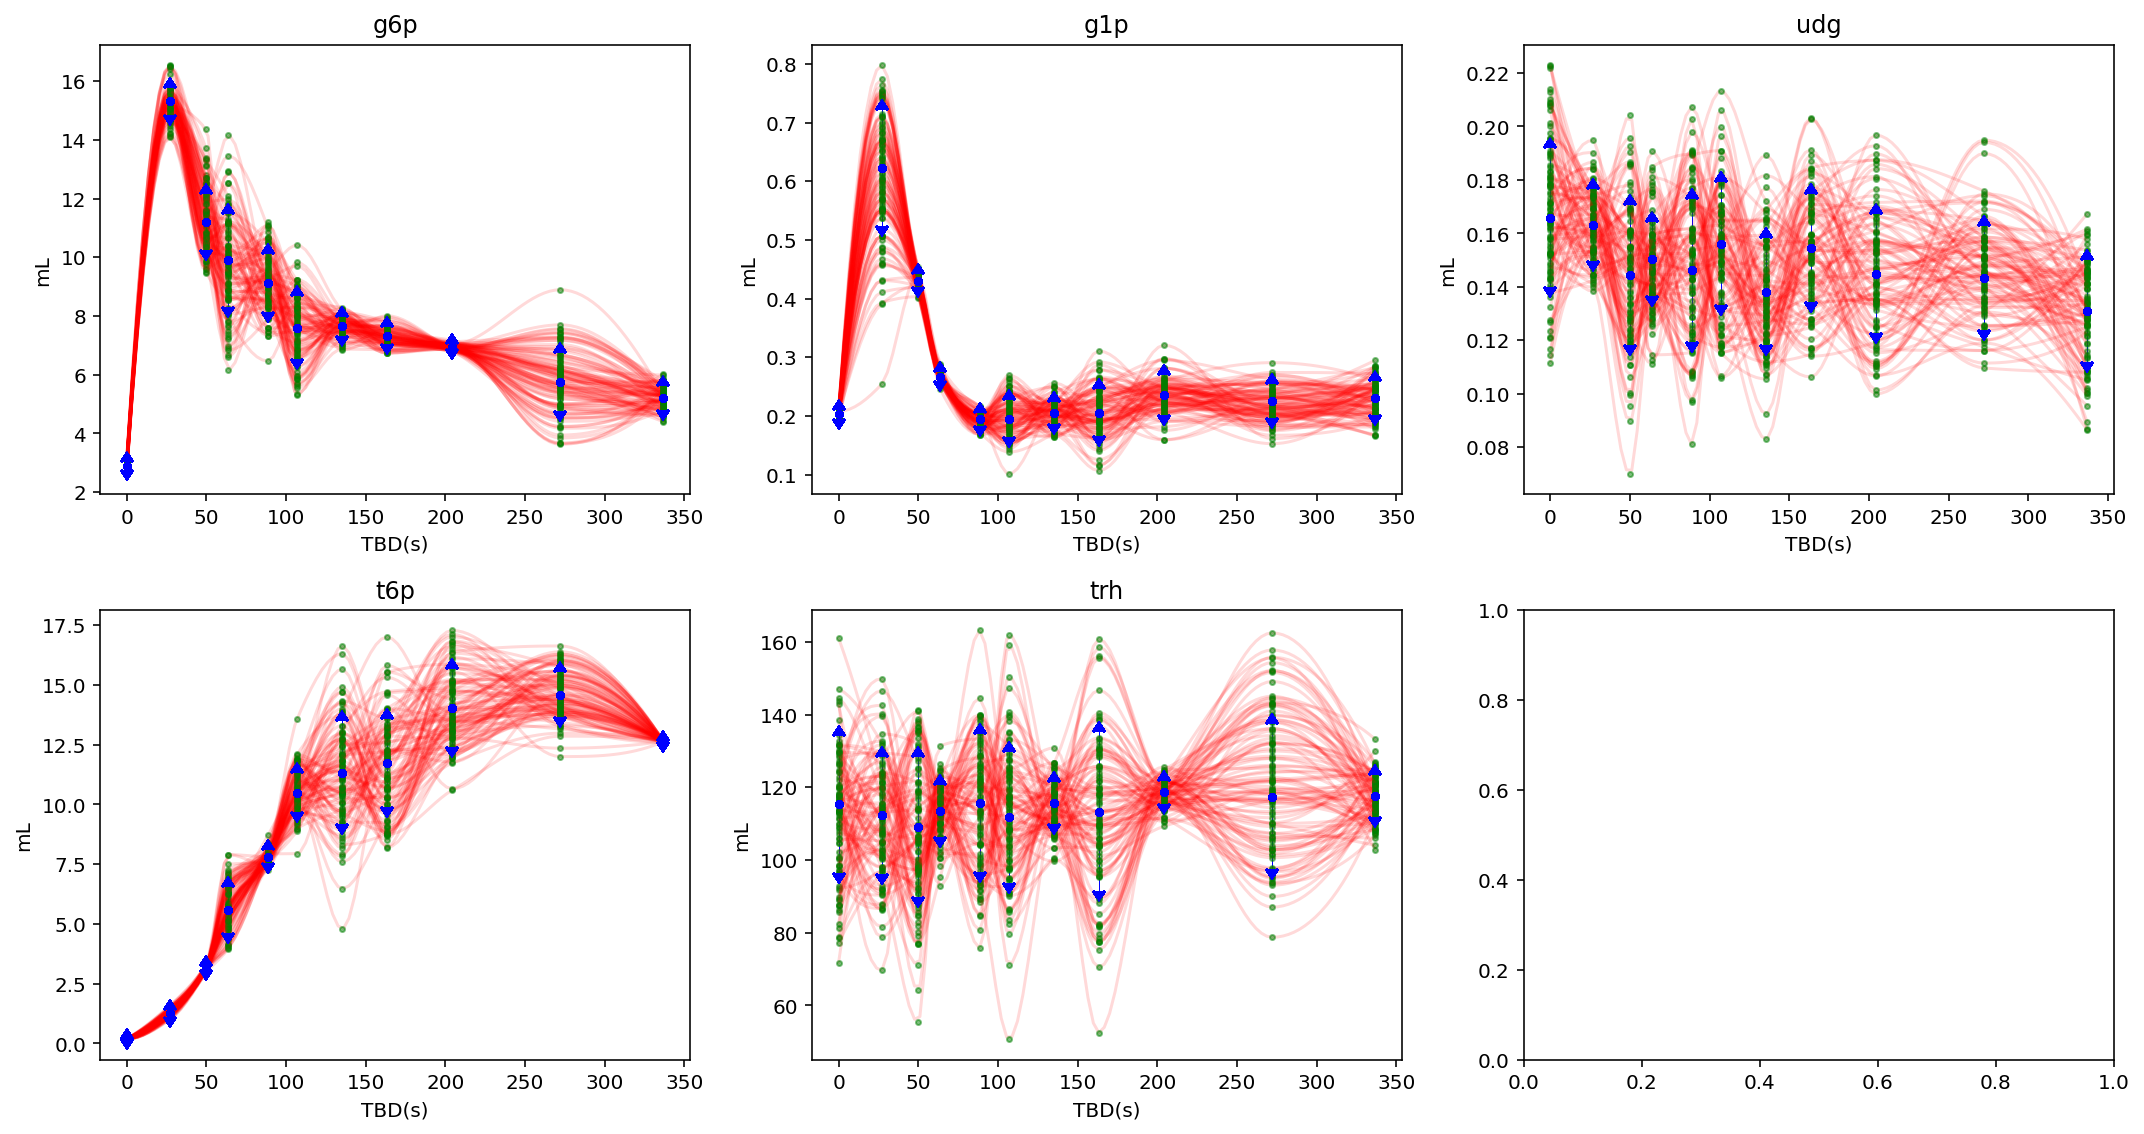

In [3]:
matpath = r"..\data\trehalose\vHeerden_trehalose_data_micromolgdw.mat"
vanHeerden = loadmat(matpath)

legenda_meta = np.squeeze(np.array(vanHeerden["data"]["legenda_metabolites"]))
meta = np.squeeze(np.array(vanHeerden["data"]["metabolites"]))
time_meta = np.squeeze(np.array(vanHeerden["data"]["time_metabolites"]))

legenda_nucleotides = np.squeeze(np.array(vanHeerden["data"]["legenda_nucleotides"]))
nucleotides = np.squeeze(np.array(vanHeerden["data"]["nucleotides"]))
time_nucleotides = np.squeeze(np.array(vanHeerden["data"]["time_nucleotides"]))

legenda_fluxes = np.squeeze(np.array(vanHeerden["data"]["legenda_fluxes"]))
fluxes = np.squeeze(np.array(vanHeerden["data"]["fluxes"]))
time_fluxes = np.squeeze(np.array(vanHeerden["data"]["time_fluxes"]))

totP = np.squeeze(np.array(vanHeerden["data"]["totP"]))
time_totP = np.squeeze(np.array(vanHeerden["data"]["time_totP"]))

# only use states, drop the fluxes

meta_std = meta * np.random.random_sample(meta.shape) * 0.2
# print(len(legenda_meta))
# print(legenda_meta)
# print(time_meta)
# print(len(meta))
# print(len(meta_std))

# create fake standard deviations
raw_meta = dict()
meta_specs = {
    "name": "van Heerden's dataset for trehalose cycle",
    "description": "For testing with simulation of Smallbone model",
    "raw_path": None,
    "groups": None,
}

meta_struct = dict()
raw_meta["t"] = time_meta
rename_map = {
    "G1P": "g1p",
    "G6P": "g6p",
    "Tre": "trh",
    "Tre6P": "t6p",
    "UDP_Glc": "udg"    
}
for i, s in enumerate(legenda_meta):
    if not s in ['G1P', 'G6P', 'Tre', 'Tre6P', 'UDP_Glc']:
        continue
    s = rename_map[s]
    raw_meta[s + "_stds"] = meta_std[:, i]
    raw_meta[s + "_means"] = meta[:, i]
    tmp = dict()
    tmp["means"] = s + "_means"
    tmp["stds"] = s + "_stds"
    tmp["time"] = "t"
    tmp["unit"] = "mL"
    tmp["time_unit"] = "TBD"
    meta_struct[s] = tmp
meta_specs["structure"] = meta_struct
raw_meta["vhd"] = raw_meta
vhd_dataset = DataSet(name="vhd", raw_data=raw_meta, data_specs=meta_specs)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plot_splines(
    vhd_dataset, 100, 100, axes=axes
)
fig.tight_layout()
# plt.show()

Now van Heerden's data is converted to a dataset that can be used to feed Smallbone's model in pyADAPT

In [4]:
from pyADAPT.examples import Smallbone2011
smallbone = Smallbone2011()

In [5]:
from pyADAPT.optimize import Optimizer, ITER, optimize

In [6]:
n_iter = 1
n_ts = 50

In [7]:
fit_params = list()

for id in smallbone.parameters.index:
    if id[-5:] == "_Vmax":
        fit_params.append(id)
fit_params

['pgi_Vmax',
 'hxt_Vmax',
 'hxk_Vmax',
 'pgm_Vmax',
 'tpp_Vmax',
 'tps_Vmax',
 'nth_Vmax',
 'ugp_Vmax']

In [8]:
adapt_result = optimize(smallbone, vhd_dataset, *fit_params, n_core=1, n_iter=1, delta_t=2)

iteration: 0 
(5, 169, 2)
[1.12409488e+03 1.04190658e+02 2.81159686e+02 3.79745919e-01
 4.56969770e+00 1.27539153e+00 1.34332659e+01 4.38547324e+01]


KeyboardInterrupt: 

In [9]:
optim = Optimizer(model=smallbone, dataset=vhd_dataset, parameter_names=fit_params)

In [15]:
optim.parameters.loc[:,'value']

pgi_Vmax    1071.0000
hxt_Vmax      97.2400
hxk_Vmax     289.6000
pgm_Vmax       0.3545
tpp_Vmax       6.5000
tps_Vmax       1.3710
nth_Vmax      15.2000
ugp_Vmax      36.8200
Name: value, dtype: float64

In [12]:
vhd_dataset.begin_time

0.0

In [12]:
optim.dataset.names

['g1p', 'g6p', 'trh', 't6p', 'udg']

In [13]:
optim.model.state_order

['glc', 'g1p', 'g6p', 'trh', 't6p', 'udg']

In [15]:
optim.parameters

,name,value,vary,lb,ub,init
pgi_Vmax,pgi_Vmax,1071.0000,False,-inf,inf,1071.0000
hxt_Vmax,hxt_Vmax,97.2400,False,-inf,inf,97.2400
hxk_Vmax,hxk_Vmax,289.6000,False,-inf,inf,289.6000
pgm_Vmax,pgm_Vmax,0.3545,False,-inf,inf,0.3545
tpp_Vmax,tpp_Vmax,6.5000,False,-inf,inf,6.5000
tps_Vmax,tps_Vmax,1.3710,False,-inf,inf,1.3710
nth_Vmax,nth_Vmax,15.2000,False,-inf,inf,15.2000
ugp_Vmax,ugp_Vmax,36.8200,False,-inf,inf,36.8200


In [16]:
optim.options

{'method': 'trf',
 'lambda_r': 1,
 'odesolver': 'RK45',
 'sseThres': 1000,
 'ss_time': 1000,
 'R': <function pyADAPT.regularization.default_regularization(params=None, parameter_trajectory=None, time_span=None, i_iter=None, i_ts=None, **kw)>,
 'interpolation': 'Hermite',
 'verbose': 1,
 'init_method': None,
 'delta_t': 0.1,
 'n_core': 4,
 'n_iter': 5,
 'init': 'PASCAL'}

In [13]:
f = lambda: np.random.normal(optim.parameters['init'], optim.parameters['init'] * 0.2)
calls = 0;
while 1:
    r = f()
    calls += 1
    if not np.all(r > 0):
        print(r)
        print(calls)
        break


[ 1.23679997e+03  7.28829610e+01  2.82861752e+02  3.44916951e-01
 -4.12933610e-02  1.61908571e+00  1.37898542e+01  4.29851896e+01]
208276


In [21]:
optim.parameters

,name,value,vary,lb,ub,init
pgi_Vmax,pgi_Vmax,1071.0000,False,-inf,inf,1071.0000
hxt_Vmax,hxt_Vmax,97.2400,False,-inf,inf,97.2400
hxk_Vmax,hxk_Vmax,289.6000,False,-inf,inf,289.6000
pgm_Vmax,pgm_Vmax,0.3545,False,-inf,inf,0.3545
tpp_Vmax,tpp_Vmax,6.5000,False,-inf,inf,6.5000
tps_Vmax,tps_Vmax,1.3710,False,-inf,inf,1.3710
nth_Vmax,nth_Vmax,15.2000,False,-inf,inf,15.2000
ugp_Vmax,ugp_Vmax,36.8200,False,-inf,inf,36.8200
